In [ ]:
# default_exp experiments

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Experiments

> API details.

In [ ]:
# export
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter, defaultdict
from icodegen.model import *
from pathlib import Path
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from typing import Dict, List, Optional

In [ ]:
#hide
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from nbdev.showdoc import *

In [ ]:
# hide
from ds4se.mgmnt.prep.i import jsonl_list_to_dataframe, get_dfs

path = Path('/home/nathan/Downloads/')
df_trn, df_val, df_tst = get_dfs(path/"java/final/jsonl")

sample = 0.01
df_trn = df_trn.sample(frac = sample)
df_val = df_val.sample(frac = sample)
df_tst = df_tst.sample(frac = sample)
df_trn.head()

,code,docstring
0,protected final void bindIndexed(Configuration...,Bind indexed elements to the supplied collecti...
1,public void setServletRegistrationBeans(\n\t\t...,Set {@link ServletRegistrationBean}s that the ...
2,public void addServletRegistrationBeans(\n\t\t...,Add {@link ServletRegistrationBean}s for the f...
3,public void setServletNames(Collection<String>...,Set servlet names that the filter will be regi...
4,public void addServletNames(String... servletN...,Add servlet names for the filter.\n@param serv...


In [ ]:
# hide
len(df_trn), len(df_val), len(df_tst)

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
trnsfr = TFGPT2LMHeadModel.from_pretrained('gpt2')
model = TransformerModel(tokenizer, trnsfr)

All model checkpoint weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
df_fake = pd.DataFrame(['test'], columns = ['code']); df_fake

,code
0,test


In [ ]:
# export
def get_mean_probs(df: pd.DataFrame, model: Model, n: Optional[int] = None):
    """
    Get the mean probability of each token that the model
    should predict for an entire pandas dataframe.

    :param df: the pandas dataframe containing each method to have the model predict on
    :param model: the model used to generate the predictions
    :param n: the number of methods to evaluate. If none, the entire dataframe will be used
    :returns: returns a numpy array of the mean probability for each token in the model's vocab
    """
    if n is None: n = len(df)

    # setup container lists for the number of occurrences and sum of probabilities for each token
    counts = [0] * len(model.tokenizer)
    sum_probs = [0.] * len(model.tokenizer)
    # loop through each method
    for mthd in df.code.values[:n]:
        # token the method and generate the probabilities for the model's predictions
        inputs = model.tokenize(mthd)
        probs = model.get_probs(inputs)[0].numpy()
        # loop through each token and its probability and update the container lists
        for idx, p in zip(inputs['input_ids'][0], probs):
            counts[idx] += 1
            sum_probs[idx] += p[idx]

    # convert the lists to numpy lists and perform element wise division to get the mean probabilities for each token
    counts = np.array(counts)
    sum_probs = np.array(sum_probs)
    return sum_probs / counts

In [ ]:
mean_probs = get_mean_probs(df_fake, model)

non_nan_idx = np.argwhere(~np.isnan(mean_probs)).flatten()
non_nan_mean_prob = mean_probs[non_nan_idx]; non_nan_mean_prob

tok_input = model.tokenize(df_fake.code.values[0])
tok_prob = model.get_probs(tok_input)[0].numpy()[0][tok_input['input_ids'][0]]; tok_prob
assert non_nan_mean_prob == tok_prob

In [ ]:
# hide
mean_probs = get_mean_probs(df_trn, model, n = 100); mean_probs

array([0.00014416, 0.00039053,        nan, ...,        nan,        nan,
              nan])

&lt;BarContainer object of 30 artists&gt;

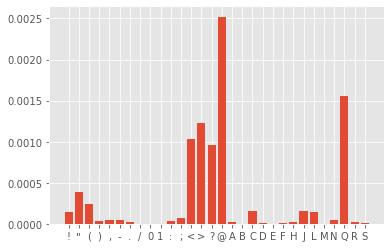

In [ ]:
# hide
non_nan_idx = np.argwhere(~np.isnan(mean_probs)).flatten()
non_nan_mean_prob = mean_probs[non_nan_idx]

plt.bar(tokenizer.convert_ids_to_tokens(non_nan_idx[:30]), non_nan_mean_prob[:30])

&lt;BarContainer object of 5 artists&gt;

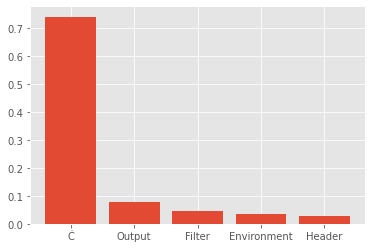

In [ ]:
# hide
k = 5

c = np.isnan(mean_probs).sum()
sorted_probs = np.argsort(mean_probs)[::-1]; sorted_probs

plt.bar(tokenizer.convert_ids_to_tokens(sorted_probs[c:c + k]), mean_probs[sorted_probs][c:c + k])

In [ ]:
df_fake = pd.DataFrame(['aaaa(bb(aaaa(bb()()ccc)dd)()ccc)dd', 'aaaa(bb()ccccc)dd'], columns = ['code']); df_fake

,code
0,aaaa(bb(aaaa(bb()()ccc)dd)()ccc)dd
1,aaaa(bb()ccccc)dd


In [ ]:
# export
# TODO: add docs and test cases
def find_parens(toks: List[str], opening: str, closing: str) -> Dict[int, int]:
    """
    From https://stackoverflow.com/a/29992065/5768407
    """
    toret = {}
    pstack = []

    for i, tok in enumerate(toks):
        if tok == opening:
            pstack.append(i)
        elif tok == closing:
            if len(pstack) == 0:
                raise IndexError("No matching closing parens at: " + str(i))
            toret[pstack.pop()] = i

    if len(pstack) > 0:
        raise IndexError("No matching opening parens at: " + str(pstack.pop()))

    return toret

def _get_range_probs(mthd: str, model: Model, opening: str, closing: str) -> Dict[int, float]:
    # Careful when using different tokenizers since HF tokenizers have diff API then HF transformers tokenizers...
    toks = model.tokenizer.tokenize(mthd)
    ranges = find_parens(toks, opening, closing)

    inputs = model.tokenize(mthd)
    probs = model.get_probs(inputs)[0].numpy()

    dist_cnts = Counter([c - o for o, c in ranges.items()])
    range_probs = defaultdict(float)
    for o, c in ranges.items():
        range_probs[c - o] += probs[c][inputs['input_ids'][0][c]]
    
    range_probs = {d: range_probs[d] / n for d, n in dist_cnts.items()}
    return range_probs

def mean_dist_probs(df: pd.DataFrame, model: Model, opening: Optional[str] = '<{>', closing: Optional[str] = '<}>', n: Optional[int] = None):
    """
    Get the mean probability of each token that the model
    should predict for an entire pandas dataframe.

    :param df: the pandas dataframe containing each method to have the model predict on
    :param model: the model used to generate the predictions
    :param n: the number of methods to evaluate. If none, the entire dataframe will be used
    :returns: returns a numpy array of the mean probability for each token in the model's vocab
    """
    if n is None: n = len(df)

    df = df.iloc[:n].copy()
    # I am not handling merging dicts across methods by summing probs with same dists...
    range_probs = df.code.apply(lambda mthd: _get_range_probs(mthd, model, opening, closing)).values

    l = []
    for probs in range_probs:
        l.extend(probs.keys())

    # merge dictionaries across methods by summing probs with the same distance. From https://stackoverflow.com/a/10461916/5768407
    range_probs = {k: sum([probs.get(k, 0) for probs in range_probs]) for k in set(l)}
    df_dist = pd.DataFrame({'dist': list(range_probs.keys()), 'avg_prob': list(range_probs.values())})
    return df_dist

In [ ]:
mean_dist_probs(df_fake, model, opening = '(', closing = ')')

,dist,avg_prob
0,16,0.000668
1,10,0.000551
2,6,0.000761


In [ ]:
# export
def get_mean_cross_entropy(df: pd.DataFrame, model: Model, n: Optional[int] = None):
    """
    Get the mean cross entropy for a model on an entire pandas dataframe

    :param df: the pandas dataframe containing each method to have the model predict on
    :param model: the model used to generate the predictions
    :param n: the number of methods to evaluate. If none, the entire dataframe will be used
    :returns: returns the mean cross entropy of the models predictions compared to true labels
    """
    if n is None: n = len(df)

    cross_entropy_losses = []
    bce = tf.keras.losses.BinaryCrossentropy(
        reduction = tf.keras.losses.Reduction.NONE
    )
    for mthd in df.code.values[:n]:
        # token the method and generate one hot encoding for the true labels
        inputs = model.tokenize(mthd)
        labels = np.zeros((len(inputs['input_ids']), len(model.tokenizer)))
        labels[np.arange(len(inputs['input_ids'])), inputs['input_ids'].numpy()] = 1

        # get the probabilities for each token from the model
        probs = model.get_probs(inputs)[0].numpy()

        # calculate the cross entropy between the labels and probabilities
        cross_entropy = bce(labels, probs).numpy()
        cross_entropy_losses.append(cross_entropy)
    
    # flatten list of cross entropies and take the mean
    cross_entropy_losses = np.concatenate(cross_entropy_losses)
    return np.mean(cross_entropy_losses)

In [ ]:
mean_cross_entropy = get_mean_cross_entropy(df_fake, model)

inputs = model.tokenize(df_fake.code.values[0])
labels = np.zeros((len(inputs['input_ids']), len(model.tokenizer)))
labels[np.arange(len(inputs['input_ids'])), inputs['input_ids'].numpy()] = 1

bce = tf.keras.losses.BinaryCrossentropy(
    reduction = tf.keras.losses.Reduction.NONE
)

probs = model.get_probs(inputs)[0].numpy()
cross_entropy = bce(labels, probs).numpy()

assert mean_cross_entropy == np.mean(cross_entropy)

In [ ]:
# hide
mean_cross_entropy = get_mean_cross_entropy(df_trn, model, n = 100); mean_cross_entropy

0.014070554